In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.misc import face
import skimage.io as skio

plt.style.use("seaborn-darkgrid")
plt.rcParams["figure.figsize"] = [9, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["axes.grid"] = False
plt.rcParams["image.cmap"] = "viridis"

rng = np.random.default_rng(seed=0)

![Pycsou](https://matthieumeo.github.io/pycsou/html/_images/pycsou.png)
# Linear inverse problems for all

# Introduction to Inverse Problems

## Inverse Problems in a Nutshell

Most real-life approximation problems can be formulated as *linear inverse problems*: 

\begin{align} \text{Find  }\mathbf{\alpha}\in\mathbb{R}^N &\text{ from noisy measurements } \mathbf{y}\sim \mathbf{Y}\\ 
   &\text{ where } \mathbb{E}[\mathbf{Y}]=\mathbf{G}\mathbf{\alpha}\;
   \text{ and }\; \mathbf{G}:\mathbb{R}^N\to \mathbb{R}^L \text{ is a linear operator.} \end{align}
   
* The data vector  $\mathbf{y}$ is assumed to be the outcome of  a random vector $\mathbf{Y}=[Y_1,\ldots,Y_L]:\Omega\rightarrow \mathbb{R}^L$, fluctuating according to some noise distribution. The entries of $\mathbb{E}[\mathbf{Y}]=\tilde{\mathbf{y}}$ are called the *ideal/noiseless measurements*.
* The measurements are assumed *unbiased* and *linear*, i.e. $\mathbb{E}[\mathbf{Y}]=\mathbf{G}\mathbf{\alpha}$, where the *sensing/forward matrix* $\mathbf{G}$ models the acquisition system.

### Example: Image Deblurring

![Deblurring](doc/images/deblurring.jpg)
*Image deblurring is a common example of inverse problem. In this case, measurements are the pixels of the original image $\alpha$ blurred by the Toeplitz sensing/forward matrix $\mathbf{G}$.*

## Inverse Problems are Ill-Posed

To solve an inverse problem one could **naively** solve the linear problem: 

$$\mathbf{y}=\mathbf{G}\mathbf{\alpha}. \label{discrete_pb}\tag{1}$$


Unfortunately, such problems are in general **ill-posed**:

* **There may exist no solutions.** If $\mathbf{G}$ is not *surjective*, $\mathcal{R}(\mathbf{G})\subsetneq \mathbb{R}^L$. Then the noisy data vector $\mathbf{y}$ may not belong to $\mathcal{R}(\mathbf{G})$, hence making (1) *unfeasible*.

* **There may exist more than one solution.** If $\mathbf{G}$ is not *injective*, $\mathcal{N}(\mathbf{G})\neq \{\mathbf{0}\}$. Therefore, if $\mathbf{\alpha}^\star$ is a solution to (1), then $\mathbf{\alpha}^\star + \mathbf{\beta}$ is also a solution $\forall\mathbf{\beta}\in \mathcal{N}(\mathbf{G})$.  

* **Solutions may be numerically unstable.** If $\mathbf{G}$ is *surjective* for example, then $\mathbf{G}^\dagger=\mathbf{G}^T(\mathbf{G}\mathbf{G}^T)^{-1}$ is a right-inverse of $\mathbf{G}$ and $\mathbf{\alpha}^\star(\mathbf{y})=\mathbf{G}^\dagger \mathbf{y}$ is a solution to (1). We have then  
$$   \|\mathbf{\alpha}^\star(\mathbf{y})\|_2\leq \|\mathbf{G}\|_2\|(\mathbf{G}^T\mathbf{G})^{-1}\|_2\|\mathbf{y}\|_2=\underbrace{\frac{\sqrt{\lambda_{max}(\mathbf{G}^T\mathbf{G})}}{\lambda_{min}(\mathbf{G}^T\mathbf{G})}}_{\text{Can be very large!}}\|\mathbf{y}\|_2, \qquad \forall \mathbf{y}\in \mathbb{R}^L.$$
The reconstruction linear map $\mathbf{y}\mapsto \mathbf{\alpha}^\star(\mathbf{y})$ can hence be **virtually unbounded** making it *unstable*.

## Regularising Inverse Problems

As a remedy to their ill-posedness, linear inverse problems are commonly solved by means of *penalised optimisation problems*, confronting the physical evidence to the analyst’s a priori beliefs about the solution (e.g. smoothness, sparsity) via a *data-fidelity* and *regularisation term*, respectively: 

$$
   \tag{2}
   \min_{\mathbf{\alpha}\in\mathbb{R}^N} \,F(\mathbf{y}, \mathbf{G} \mathbf{\alpha})\quad+\quad \lambda\mathcal{R}(\mathbf{\alpha}).
  $$

* $F:\mathbb{R}^L\times \mathbb{R}^L\rightarrow \mathbb{R}_+\cup\{+\infty\}$ is called a **loss functional**, measuring the discrepancy between the *observed* and *predicted* measurements $\mathbf{y}$ and $\mathbf{G}\mathbf{\alpha}$ respectively.

* $\mathcal{R}:\mathbb{R}^N\to \mathbb{R}_+\cup\{+\infty\}$ is a **penalty functional** favouring simple and well-behaved solutions (typically with a finite number of degrees of freedom). 


* $\lambda>0$ is a **penalty parameter** which controls the amount of regularisation by putting the regularisation functional and the cost functional on a similar scale.

> Note: We restrict our attention to *proper, convex and  lower semi-continuous* loss and penalty functionals. 


### Choosing the Loss Functional

The loss functional can be chosen as the *negative log-likelihood* of the data $\mathbf{y}$:

$$ F(\mathbf{y},\mathbf{G} \mathbf{\alpha})=-\ell(\mathbf{\alpha}\vert\mathbf{y})=-\log p_{Y_1,\ldots,Y_L}\left(y_1,\ldots,y_L | \mathbf{\alpha}\right).$$

When the noise distribution is not fully known or the likelihood too complex, one can also use general $\ell_p$ cost functionals 

$$ F(\mathbf{y},\mathbf{G}\mathbf{\alpha})=\Vert\mathbf{y}-\mathbf{G}\mathbf{\alpha}\Vert_p^p=\sum_{i=1}^L\left\vert y_i-\sum_{n=1}^NG_{in} \alpha_n\right\vert^p,$$

where $p\in [1,+\infty]$ is typically chosen according to the tail behaviour of the noise distribution.


![lp_cost](doc/images/lp_cost.png)

### Choosing the Penalty

The penalty/regularisation functional is used to favour *physically-admissible solutions with simple behaviours*. It can be interpreted as implementing **Occam’s razor principle**.

In essence, this principle states that when two equally good explanations for a given phenomenon are available, one should **always favour the simplest**, i.e. the one that introduces the least explanatory variables.
What exactly is meant by "simple" solutions will depend on the specific application at hand. 

Common choices of regularisation strategies include: *Tikhonov regularisation* $\|\mathbf{D}\cdot\|_2^2$, *TV regularisation* $\|\mathbf{D}\cdot\|_1$, *elastic net regularisation* $\gamma\|\mathbf{D}_1\cdot\|_2^2 + (1-\gamma) \|\mathbf{D}_2\cdot\|_1$, *maximum entropy regularisation*, etc...


## Proximal Algorithms
Most optimisation problems used to solve inverse problems in practice take the form: 

$${\min_{\mathbf{x}\in\mathbb{R}^N} \;\mathcal{F}(\mathbf{x})\;\;+\;\;\mathcal{G}(\mathbf{x})\;\;+\;\;\mathcal{H}(\mathbf{K} \mathbf{x})} \tag{3}$$

where:
* $\mathcal{F}:\mathbb{R}^N\rightarrow \mathbb{R}$ is *convex* and *differentiable*, with $\beta$-*Lipschitz continuous* gradient.
* $\mathcal{G}:\mathbb{R}^N\rightarrow \mathbb{R}\cup\{+\infty\}$ and $\mathcal{H}:\mathbb{R}^M\rightarrow \mathbb{R}\cup\{+\infty\}$ are two *proper*, *lower semicontinuous* and *convex functions* with *simple proximal operators*.

* $\mathbf{K}:\mathbb{R}^N\rightarrow \mathbb{R}^M$ is a *linear operator*.

#### Example:
$$\min_{\mathbf{x}\in\mathbb{R}^N}\frac{1}{2}\left\|\mathbf{y}-\mathbf{G}\mathbf{x}\right\|_2^2\quad+\quad\lambda_1 \|\mathbf{D}\mathbf{x}\|_1\quad+\quad\lambda_2 \|\mathbf{x}\|_1,$$

with $\mathbf{D}\in\mathbb{R}^{N\times N}$ and $\mathbf{G}\in\mathbb{R}^{L\times N}, \, \mathbf{y}\in\mathbb{R}^L, \lambda_1,\lambda_2>0.$ This problem can be written in the form 

$${\min_{\mathbf{x}\in\mathbb{R}^N} \;\mathcal{F}(\mathbf{x})\;\;+\;\;\mathcal{G}(\mathbf{x})\;\;+\;\;\mathcal{H}(\mathbf{K} \mathbf{x})}$$

by choosing $\mathcal{F}(\mathbf{x})= \frac{1}{2}\left\|\mathbf{y}-\mathbf{G}\mathbf{x}\right\|_2^2$, $\mathcal{G}(\mathbf{x})=\lambda_2\|\mathbf{x}\|_1$,
    $\mathcal{H}(\mathbf{x})=\lambda_1 \|\mathbf{x}\|_1$ and $\mathbf{K}=\mathbf{D}$.

Problems of the form (3) can be solved by means of iterative **proximal algorithms**:

* **Primal-dual splitting:** solves for problems of the form \
${\min_{\mathbf{x}\in\mathbb{R}^N} \;\mathcal{F}(\mathbf{x})\;\;+\;\;\mathcal{G}(\mathbf{x})\;\;+\;\;\mathcal{H}(\mathbf{K} \mathbf{x})}$
* **Chambolle Pock splitting:** solves for problems of the form \
${\min_{\mathbf{x}\in\mathbb{R}^N} \;\mathcal{G}(\mathbf{x})\;\;+\;\;\mathcal{H}(\mathbf{K} \mathbf{x})}$
* **Douglas Rachford splitting/ADMM:** solves for problems of the form \
${\min_{\mathbf{x}\in\mathbb{R}^N} \;\mathcal{G}(\mathbf{x})\;\;+\;\;\mathcal{H}(\mathbf{x})}$
* **Forward-Backward splitting/APGD:** solves for problems of the form \
$\min_{\mathbf{x}\in\mathbb{R}^N} \;\mathcal{F}(\mathbf{x})\;\;+\;\;\mathcal{G}(\mathbf{x})$
 
These are all **first-order algorithms**: they rely only on the gradient of $\mathcal{F}$, and/or the proximal operators of $\mathcal{G}, \mathcal{H}$, and/or matrix/vector multiplications with $\mathbf{K}$ and $\mathbf{K}^T$.

# Solving Inverse Problems with `Pycsou`

## Designing Convex Optimisation Problems

`Pycsou` is a *Python 3 package* for solving linear inverse problems with state-of-the-art proximal algorithms. The library provides abstract classes for the main building blocks of generic penalised convex optimisation problems:

- linear operators,
- loss functionals,
- penalty functionals,
-proximal algorithms.

Penalised convex optimisation problems can then be constructed by *adding*, *subtracting*, *scaling*, *composing*, *exponentiating* or *stacking* together the various linear operators and functionals shipped with Pycsou (or custom, user-defined ones). 

## Multidimensional Maps

Pycsou's base classes for functionals and linear operators both inherit from the abstract class `Map` with signature: 

```python
class Map(shape: Tuple[int, int], is_linear: bool = False, 
          is_differentiable: bool = False): 
``` 

This is the base class for *multidimensional maps* (potentially nonlinear) $\mathbf{h}:\mathbb{R}^M\to\mathbb{R}^N$. 

Any instance/subclass of this class must at least implement the abstract method `__call__` for *pointwise evaluation*.

### Operations on `Map` Instances

The class `Map` supports the following arithmetic operators `+`, `-`, `*`, `@`, `**` and `/`, implemented with the class methods `__add__/__radd__`, `__sub__/__neg__`, `__mul__/__rmul__`, `__matmul__`, `__pow__`,`__truediv__`. 
Such arithmetic operators can be used to *add, substract, scale, compose, exponentiate or evaluate* `Map` instances. The `__call__` methods of `Map` objects constructed this way are automatically computed:

```python
>>> f3 = f1 / 3 + np.pi * f2
>>> np.allclose(f3(x), f1(x) / 3 + np.pi * f2(x))
True
>>> h3 = h1 * 3 - (h2 ** 2) / 6
>>> np.allclose(h3(x), h1(x) * 3 - (h2(h2(x))) / 6)
True
```

Note that multiplying a map with an array is the same as evaluating the map at the array:

```python
>>> np.allclose(h * x, h(x))
True
```

The multiplication operator `@` can also be used in place of `*`, in compliance with Numpy’s interface:

```python
>>> np.allclose(h * x, h @ x), np.allclose((h1 * h2)(x), (h1 @ h2)(x))
True, True
```

Finally, maps can be shifted via the method `shifter`:

```python
>>> h=g.shifter(shift=2 * x)
>>> np.allclose(h(x), g(x + 2 * x))
True
```


### Differentiable Maps
An important subclass of `Map` is `DifferentiableMap` which is the base class for differentiable maps. It has the following signature:

```python
class DifferentiableMap(shape: Tuple[int, int],is_linear: bool = False,
                        lipschitz_cst: float = inf,
                        diff_lipschitz_cst: float = inf):
```

Any instance/subclass of this class must implement the abstract methods `__call__` and `jacobianT` which returns the **transpose** of the *Jacobian matrix*
$$ (\mathbf{J}_{\mathbf{h}}(\mathbf{x}))_{ij}:=\frac{\partial h_i}{\partial x_j}(\mathbf{x})$$
of the multidimensional $\mathbf{h}=[h_1, \ldots, h_N]: \mathbb{R}^M\to\mathbb{R}^N$ at a given point $\mathbf{x}\in\mathbb{R}^M$.

### Operations on `DifferentiableMap` Instances

Standard arithmetic operators can also be used on `DifferentiableMap` instances so as to *add, substract, scale, compose, exponentiate or evaluate* them. The attributes `lipschitz_cst`, `diff_lipschitz_cst` and the method `jacobianT` are automatically updated using standard differentiation rules.

```python
>>> map_ = f * g
>>> np.allclose(map_.lipschitz_cst, f.lipschitz_cst * g.lipschitz_cst)
True
>>> np.allclose(map_.jacobianT(x), g.jacobianT(x) * f.jacobianT(g(x)))
True
```


## Functionals

Functionals are (real) single-valued maps $h:\mathbb{R}^N\to \mathbb{R}$. They can be implemented via a subclass of `Map` called `Functional`:

```python
class Functional(dim: int, 
                 data: Optional[numpy.ndarray] = None,
                 is_differentiable: bool = False, 
                 is_linear: bool = False)
``` 
For differentiable functionals, the subclass `DifferentiableFunctional` can be used. 
The latter admits a method `gradient` which is an *alias* for the abstract method `jacobianT`.

> Reminder: for a functional $h$, $\mathbf{J}_h(\mathbf{x})=\nabla h (\mathbf{x})$.

### Proximable Functionals
We say that a functional $f:\mathbb{R}^N\to \mathbb{R}$ is *proximable* is its **proximity operator**

$$\mathbf{\text{prox}}_{\tau f}(\mathbf{z}):=\arg\min_{\mathbf{x}\in\mathbb{R}^N} f(x)+\frac{1}{2\tau} \|\mathbf{x}-\mathbf{z}\|_2^2, \quad \forall \mathbf{z}\in\mathbb{R}^N,$$

admits a *simple closed-form expression* **or** can be evaluated *efficiently* and with *high accuracy*.

They are represented by the subclass `ProximableFunctional`. The latter has  signature:

```python
class ProximableFunctional(dim: int, 
                           data: Optional[numpy.ndarray] = None, 
                           is_differentiable: bool = False, 
                           is_linear: bool = False)
```
Every subclass/instance of `ProximableFunctional` must at least implement the abstract methods `__call__` **and** `prox`.

### Operations on  Proximable Functionals

For the following basic operations, the proximal operator can be automatically updated:

- **Postcomposition:** $g(\mathbf{x})=\alpha f(\mathbf{x})$,
- **Precomposition:** $g(\mathbf{x})= f(\alpha\mathbf{x}+b)$ or $g(\mathbf{x})= f(U\mathbf{x})$ with $U$ a *unitary operator*,
- **Affine Sum:** $g(\mathbf{x})= f(\mathbf{x})+\mathbf{a}^T\mathbf{x}.$

```python
>>> from pycsou.func.penalty import L1Norm
>>> func = L1Norm(dim=10)
>>> x = np.arange(10); tau=0.1
>>> np.allclose((2 * func).prox(x, tau), func.prox(x, 2 * tau))
True
>>> np.allclose((func * 2).prox(x, tau), func.prox(x * 2, 4 * tau)/2)
True
>>> np.allclose(func.shifter(x/2).prox(x, tau), func.prox(x+x/2, tau)-x/2)
True
```

### Horizontal Stacking of Proximable Functionals

The class `ProxFuncHStack` allows to stack many functionals $\{f_i:\mathbb{R}^{N_i}\to \mathbb{R}, i=1,\ldots, k\}$ horizontally:

$$h:\begin{cases}\mathbb{R}^{N_1}\times \cdots \times\mathbb{R}^{N_k}\to \mathbb{R}\\
   (\mathbf{x}_1,\ldots, \mathbf{x}_k)\mapsto \sum_{i=1}^k f_i(\mathbf{x}_i).
   \end{cases}$$

The proximity operator of the stacked functional $h$ is moreover computed automatically (and soon in parallel) via the formula:

$$\mathbf{\text{prox}}_{\tau h}(\mathbf{x}_1,\ldots, \mathbf{x}_k)=\left(\mathbf{\text{prox}}_{\tau f_1}(\mathbf{x}_1),\ldots, \mathbf{\text{prox}}_{\tau f_k}(\mathbf{x}_k)\right).$$


### List of Functionals Available in Pycsou
#### Norms
![penalties](doc/images/penalty_norms.png)

#### Balls
![penalties](doc/images/penalty_balls.png)

#### Convex Sets
![penalties](doc/images/penalty_convex.png)

#### Information Theoretic
![penalties](doc/images/penalty_information.png)

#### Divergences
![penalties](doc/images/penalty_div.png)

#### Losses
![penalties](doc/images/penalty_loss.png)

### Implementing New Differentiable Functionals

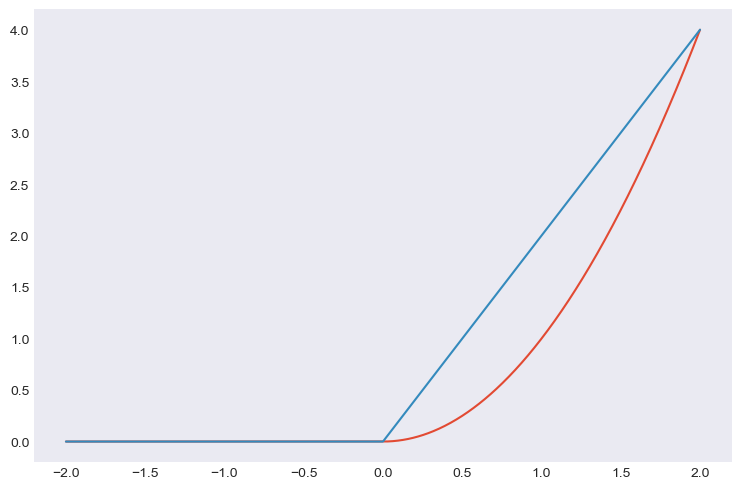

In [209]:
from pycsou.core import DifferentiableFunctional

class OneSidedSquaredL2Norm(DifferentiableFunctional):
    def __init__(self, dim: int):
        super(OneSidedSquaredL2Norm, self).__init__(dim=dim)

    def __call__(self, x: np.ndarray) -> np.ndarray: #Implement abstract method __call__
        return np.sum(x**2 * (x >= 0))

    def jacobianT(self, x: np.ndarray) -> np.ndarray: #Implement abstract method jacobianT
        return 2 * x * (x >= 0)
    
x=np.linspace(-2,2,1000)
func=OneSidedSquaredL2Norm(dim=1)
y = [func(t) for t in x]; dy = [func.gradient(t) for t in x]
plt.plot(x,y); plt.plot(x,dy)

## Linear Operators

The base class for linear operators $\mathbf{L}:\mathbb{R}^N\to \mathbb{R}^M$ is `LinearOperator`, a subclass of `DifferentiableMap` with signature: 

```python
class LinearOperator(shape: Tuple[int, int], dtype: Optional[type] = None, 
                    is_explicit: bool = False, is_dense: bool = False, 
                    is_sparse: bool = False, is_dask: bool = False, 
                    is_symmetric: bool = False, 
                    lipschitz_cst: float = inf)
```
Any instance/subclass of this class must at least implement the abstract methods `__call__` for *forward evaluation* $\mathbf{L}\mathbf{x}$ **and** `adjoint` for *backward evaluation* $\mathbf{L}^\ast\mathbf{y}$ where $\mathbf{L}^\ast:\mathbb{R}^M\to \mathbb{R}^N$ is the *adjoint* of $\mathbf{L}$ defined as:
$$\langle \mathbf{x}, \mathbf{L}^\ast\mathbf{y}\rangle_{\mathbb{R}^N}:=\langle \mathbf{L}\mathbf{x}, \mathbf{y}\rangle_{\mathbb{R}^M}, \qquad\forall (\mathbf{x},\mathbf{y})\in \mathbb{R}^N\times \mathbb{R}^M.$$

### Matrix-Free Operators

Pycsou's linear operators are inherently **matrix-free**: the operator $\mathbf{L}$ needs not be stored as an *array* since the methods `__call__` (alias `matvec`) and `adjoint` can be used to perform  matrix-vector products $\mathbf{L}\mathbf{x}$ and $\mathbf{L}^\ast\mathbf{y}$ respectively. This is particularly useful when the dimensions $N$ and $M$ are **very large** (e.g. in *image processing*) and $\mathbf{L}$ cannot be stored in memory as a Numpy array.

The class `pycsou.core.LinearOperator` can be thought as an *interface-compatible overload* of the standard matrix-free classes  `pylops.LinearOperator` and `scipy.sparse.linalg.LinearOperator` from PyLops and Scipy respectively.

Pycsou's `LinearOperator` introduces notably the method `jacobianT`, useful for automatic differentiation when composing linear operators with differentiable functionals:

$$\mathbf{J}^T_{\mathbf{L}}(\mathbf{x}):=\mathbf{L}^T, \;\forall\mathbf{x}\in\mathbb{R}^N.$$

It also introduces convenience linear algebra methods such as `eigenvals`, `svds`, `pinv`, `cond`, etc. 

### Explicit Operators

Sometimes it can be cumbersome to specify an operator in matrix-free form. In which case, Pycsou's class `ExplicitLinearOperator` can be used to construct linear operators from array-like representations: 

```python
class ExplicitLinearOperator(array: Union[numpy.ndarray, 
                                          scipy.sparse.base.spmatrix, 
                                          dask.array.core.Array],
                             is_symmetric: bool = False)
```

This class takes as input *Numpy arrays*, *Scipy sparse matrices* (in any sparse format) or *Dask distributed arrays*. 

Finally, matrix-free operators can be converted into explicit operators via the methods `todense` or `tosparse` (useful for visualisation/debugging but often **memory intensive**).


### Operations on Linear Operators

Just like `DifferentiableMap`, the class `LinearOperator` supports the whole set of arithmetic operations: `+`, `-`, `*`, `@`, `**` and `/`. '

The abstract  methods `__call__`, `jacobianT` and `adjoint` of `LinearOperator` instances resulting from arithmetic operations are automatically updated.

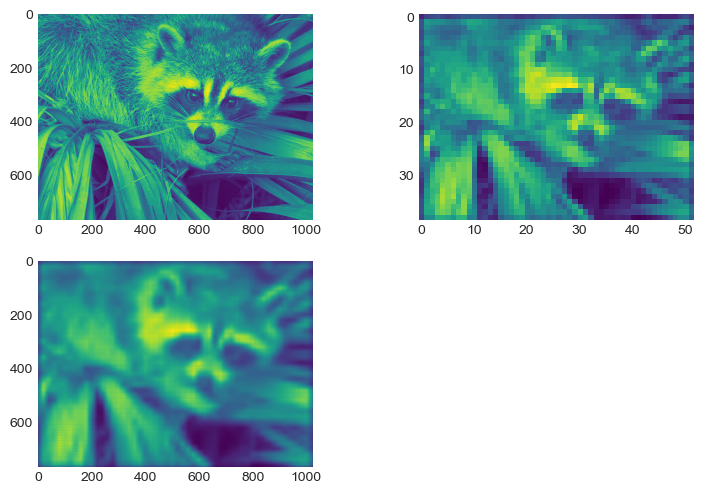

In [210]:
from pycsou.linop import Convolve2D, DownSampling

input_image = face(gray=True)
filter_size = 40
filter_support = np.linspace(-3, 3, filter_size)
gaussian_filter = np.exp(-(filter_support[:, None]
                           ** 2 + filter_support[None, :] ** 2) / 2 * (0.5))

FilterOp = Convolve2D(size=input_image.size,
                      filter=gaussian_filter, shape=input_image.shape)
DownSamplingOp = DownSampling(
    size=input_image.size, downsampling_factor=20, shape=input_image.shape)
BlurringOp = DownSamplingOp * FilterOp # Compose a filtering operator with a downsampling operator.

blurred_image = (BlurringOp * input_image.flatten()
                 ).reshape(DownSamplingOp.output_shape) # Method __call__ of composite operator is available.
backproj_image = BlurringOp.adjoint(
    blurred_image.flatten()).reshape(input_image.shape) # Method adjoint of composite operator is available.

plt.figure()
plt.subplot(2, 2, 1)
plt.imshow(input_image)
plt.subplot(2, 2, 2)
plt.imshow(blurred_image)
plt.subplot(2, 2, 3)
plt.imshow(backproj_image)

It is also possible to stack `LinearOperator` instances horizontally/vertically via the class `LinOpStack`:

Text(0.5, 1.0, '$\\partial f/\\partial y$')

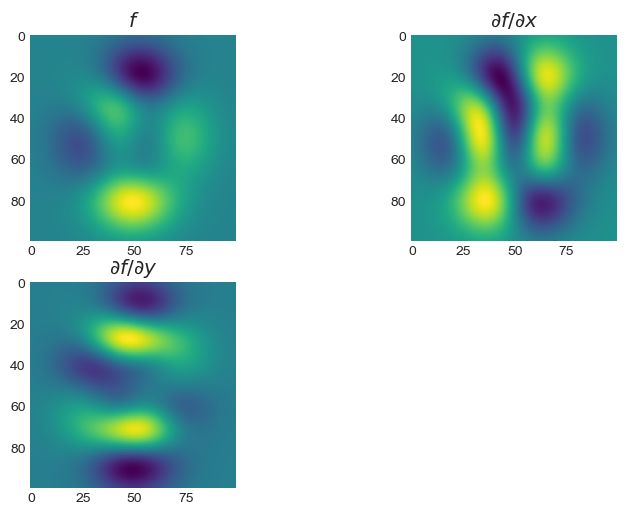

In [211]:
from pycsou.linop import FirstDerivative, LinOpStack
from pycsou.util import peaks

x = np.linspace(-2.5, 2.5, 100)
X,Y = np.meshgrid(x,x)
Z = peaks(X, Y)

D1 = FirstDerivative(size=Z.size, shape=Z.shape, axis=1, 
                         kind='centered')
D2 = FirstDerivative(size=Z.size, shape=Z.shape, axis=0, 
                         kind='centered')
Gradient = LinOpStack(D1, D2, axis=0) # Form the gradient by stacking 1D derivative operators

DZ=Gradient(Z.flatten())

plt.figure(); plt.subplot(2,2,1)
plt.imshow(Z)
plt.title('$f$'); plt.subplot(2,2,2)
plt.imshow(DZ[:Z.size].reshape(Z.shape))
plt.title('$\\partial f/\\partial x$'); plt.subplot(2,2,3)
plt.imshow(DZ[Z.size:].reshape(Z.shape))
plt.title('$\\partial f/\\partial y$')

### Some Linear Operators Available in Pycsou

### Convolution Operators

![operators](doc/images/conv_op.png)

### Differential Operators

![operators](doc/images/diff_op.png)

### Sampling Operators

![operators](doc/images/samp_op.png)


## Implementing New Linear Operators

In [212]:
from pycsou.core import LinearOperator

class RepCol(LinearOperator):
    def __init__(self, size: int, reps: int, dtype: type = np.float64):
        self.reps = reps
        super(RepCol, self).__init__(shape=(size*reps, size))

    def __call__(self, x: np.ndarray) -> np.ndarray:
        return np.tile(x[:,None], (1, self.reps)).flatten()

    def adjoint(self, y: np.ndarray) -> np.ndarray:
        return np.sum(y.reshape(self.shape[1], reps), axis=-1).flatten()
    
x =np.arange(4)
Op=RepCol(x.size, 5)
y=Op(x).reshape(x.size,5)
print(y)

[[0 0 0 0 0]
 [1 1 1 1 1]
 [2 2 2 2 2]
 [3 3 3 3 3]]


## Pycsou Class Diagram
![Pycsou UML](doc/images/Pycsou_UML.png)

# Algorithms

The base class for Pycsou's iterative algorithms is `GenericIterativeAlgorithm`:

```python 
class GenericIterativeAlgorithm(objective_functional: pycsou.core.map.Map,
                                init_iterand: Any, 
                                max_iter: int = 500, 
                                min_iter: int = 10, 
                                accuracy_threshold: float = 0.001, 
                                verbose: Optional[int] = None)
```

Any instance/subclass of this class must at least implement the abstract methods `update_iterand`, `print_diagnostics`, `update_diagnostics` and `stopping_metric`.

## Primal Dual Splitting Method (PDS) 
Most algorithms shipped with Pycsou (FBS, APGD, ADMM, CPS, DRS, etc) are special cases of Condat's *primal-dual splitting method (PDS)* implemented in the class `PrimalDualSplitting` (alias `PDS`):

```python 
class PrimalDualSplitting(dim: int, 
                          F: Optional[DifferentiableMap] = None, 
                          G: Optional[ProximableFunctional] = None, 
                          H: Optional[ProximableFunctional] = None,
                          K: Optional[LinearOperator] = None, 
                          tau: Optional[float] = None, 
                          sigma: Optional[float] = None, 
                          rho: Optional[float] = None, 
                          beta: Optional[float] = None, 
                          ...)
```

The user must simply put its problem in the form ${\min_{\mathbf{x}\in\mathbb{R}^N} \;\mathcal{F}(\mathbf{x})\;\;+\;\;\mathcal{G}(\mathbf{x})\;\;+\;\;\mathcal{H}(\mathbf{K} \mathbf{x})}$ and provide the relevant terms to the class constructor.


## Hyperparameters Auto-tuning 

For convergence of the algorithm, the step sizes/momentum parameter $\tau$, $\sigma$ and $\rho$ must verify:

* If the Lipschitz constant $\beta$ of $\nabla \mathcal{F}$ is *positive*:
  - $\frac{1}{\tau}-\sigma\Vert\mathbf{K}\Vert_{2}^2\geq \frac{\beta}{2}$,
  - $\rho \in ]0,\delta[$, where $\delta:=2-\frac{\beta}{2}\left(\frac{1}{\tau}-\sigma\Vert\mathbf{K}\Vert_{2}^2\right)^{-1}\in[1,2[.$

* If the Lipschitz constant $\beta$ of $\nabla \mathcal{F}$ is *null* (e.g. $\mathcal{F}=0$):
  - $\tau\sigma\Vert\mathbf{K}\Vert_{2}^2\leq 1$
  - $\rho \in [\epsilon,2-\epsilon]$, for some  $\epsilon>0.$


When the user does not specify hyperparameters, we choose the step sizes *as large as possible* and *perfectly balanced* (improves practical convergence speed): 

* $\beta>0$: 
$$\tau=\sigma=\frac{1}{\Vert\mathbf{K}\Vert_{2}^2}\left(-\frac{\beta}{4}+\sqrt{\frac{\beta^2}{16}+\Vert\mathbf{K}\Vert_{2}^2}\right).$$
* $\beta=0$:
$$\tau=\sigma=\Vert\mathbf{K}\Vert_{2}^{-1}.$$

The momentum term $\rho$ is chosen as $\rho=0.9$ ($\beta>0$) or $\rho=1$ ($\beta=0$).

> $\Vert\mathbf{K}\Vert_{2}$ can be computed efficiently via the method `LinearOperator.compute_lipschitz_cst` which relies on Scipy's sparse linear algebra routines `eigs`/`eigsh`/`svds`.

### Example:
$$\min_{\mathbf{x}\in\mathbb{R}^N}\frac{1}{2}\left\|\mathbf{y}-\mathbf{G}\mathbf{x}\right\|_2^2\quad+\quad\lambda_1 \|\mathbf{D}\mathbf{x}\|_1\quad+\quad\lambda_2 \|\mathbf{x}\|_1,$$

with $\mathbf{D}\in\mathbb{R}^{N\times N}$ and $\mathbf{G}\in\mathbb{R}^{L\times N}, \, \mathbf{y}\in\mathbb{R}^L, \lambda_1,\lambda_2>0.$ This problem can be written in the form 

$${\min_{\mathbf{x}\in\mathbb{R}^N} \;\mathcal{F}(\mathbf{x})\;\;+\;\;\mathcal{G}(\mathbf{x})\;\;+\;\;\mathcal{H}(\mathbf{K} \mathbf{x})}$$

by choosing $\mathcal{F}(\mathbf{x})= \frac{1}{2}\left\|\mathbf{y}-\mathbf{G}\mathbf{x}\right\|_2^2$, $\mathcal{G}(\mathbf{x})=\lambda_2\|\mathbf{x}\|_1$,
    $\mathcal{H}(\mathbf{x})=\lambda_1 \|\mathbf{x}\|_1$ and $\mathbf{K}=\mathbf{D}$.

/Users/mmjasime/Documents/Github/pycsou/pycsou/opt/proxalgs.py:374: RuntimeWarning: divide by zero encountered in double_scalars
  self.old_iterand['primal_variable'])
/Users/mmjasime/Documents/Github/pycsou/pycsou/opt/proxalgs.py:377: RuntimeWarning: divide by zero encountered in double_scalars
  self.old_iterand['dual_variable'])


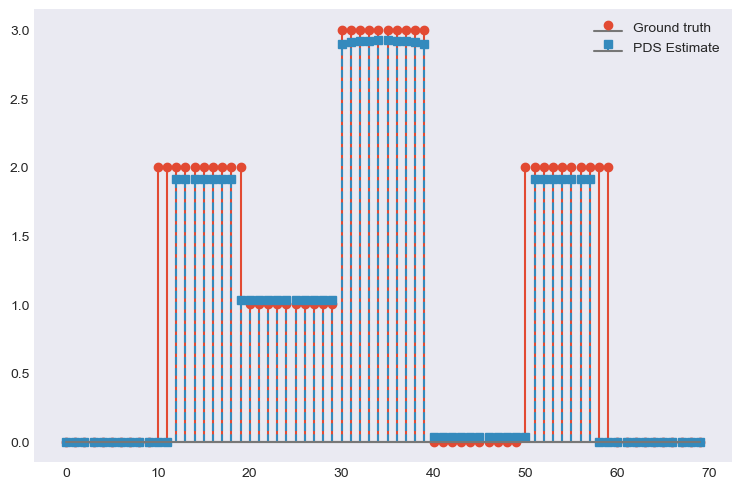

In [213]:
from pycsou.linop import FirstDerivative, DownSampling
from pycsou.func import SquaredL2Loss, L1Norm, NonNegativeOrthant
from pycsou.opt import PrimalDualSplitting

x = np.repeat([0, 2, 1, 3, 0, 2, 0], 10) # Ground truth
D = FirstDerivative(size=x.size, kind='forward') # Regularisation operator 
D.compute_lipschitz_cst(tol=1e-3)
G = DownSampling(size=x.size, downsampling_factor=3) # Downsampling operator
G.compute_lipschitz_cst() # Compute Lipschitz constant for automatic parameter tuning
y = G(x) # Input data (downsampled x)

l22_loss = (1 / 2) * SquaredL2Loss(dim=G.shape[0], data=y) # Least-squares loss
F = l22_loss * G # Differentiable term F
H = 0.1 * L1Norm(dim=D.shape[0]) # Proximable term H
G = 0.01 * L1Norm(dim=G.shape[1]) # Proximable term F
pds = PrimalDualSplitting(dim=G.shape[1], F=F, G=G, H=H, K=D, verbose=None) # Initialise PDS
estimate, converged, diagnostics = pds.iterate() # Run PDS

plt.figure()
plt.stem(x, linefmt='C0-', markerfmt='C0o') 
plt.stem(estimate['primal_variable'], linefmt='C1--', markerfmt='C1s')
plt.legend(['Ground truth', 'PDS Estimate'])
plt.show()

## List of Proximal Algorithms available in Pycsou
![algorithms](doc/images/algorithms.png)

# Demo: Image Inpainting

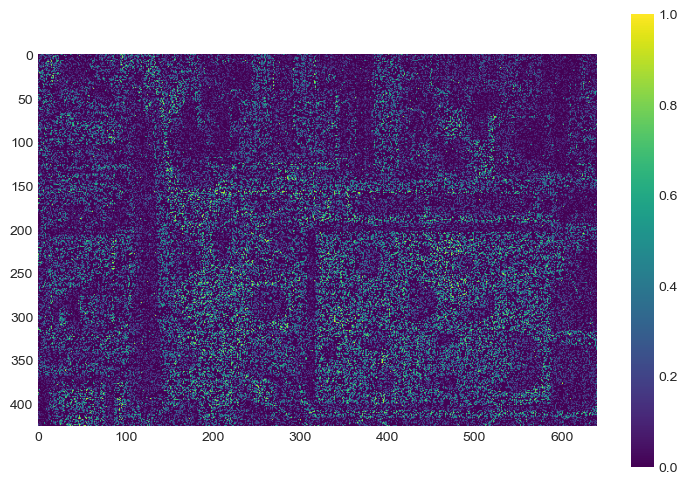

In [214]:
from pycsou.linop import Masking

input_image = skio.imread("doc/images/image.jpg", as_gray=True).astype(np.float64) # Load input image

# Define forward mask operator
bool_mask = (rng.binomial(1, p=0.25, size=input_image.size).astype(bool)
             .reshape(input_image.shape))
Gop = Masking(size=input_image.size, sampling_bool=bool_mask.flatten())
Gop.compute_lipschitz_cst()

# Generate noisy data
y = Gop(input_image.flatten())
y[rng.binomial(n=1, p=0.02, size=y.size).astype(bool)] = 1.0 # 2% of data polluted by shot noise

# Backproject noisy data using the adjoint
backprojected_image = Gop.adjoint(y).reshape(input_image.shape)
plt.imshow(backprojected_image)
plt.colorbar()

## Tikhonov-regularised Least-Squares
$$\min_{\mathbf{x}\in\mathbb{R}^N} \underbrace{\frac{1}{2}\left\| \mathbf{y}-\mathbf{G}\mathbf{x}\right\|_2^2\quad+\quad\frac{\mu}{2}\|\mathbf{D}\mathbf{x}\|_2^2}_{\mathcal{F}(\mathbf{x})} \quad +\quad \underbrace{\iota{[0,1]}(\mathbf{x})}_{\mathcal{G}(\mathbf{x})}$$

We have: 
* $\mathcal{F}(\mathbf{x}):=(1/2)\left\| \mathbf{y}-\mathbf{G}\mathbf{x}\right\|_2^2+(\mu/2)\|\mathbf{D}\mathbf{x}\|_2^2$ differentiable with $\beta$-Lipschitz continuous gradient 
$$\nabla\mathcal{F}(\mathbf{x})=\mathbf{G}^T(\mathbf{G}\mathbf{x}-\mathbf{y})+\mu \mathbf{D}^T\mathbf{D}\mathbf{x},$$ $\beta=\|\mathbf{G}^T\mathbf{G}+\mu\mathbf{D}^T\mathbf{D}\|_2$.
* $\mathcal{G}(\mathbf{x}):=\iota{[0,1]}(\mathbf{x})$ is *proximable*, with 
$$(\mathbf{\text{prox}}_{\tau\iota_{[0,1]}}(\mathbf{x}))_n=\begin{cases}x_n &\text{if } x_n\in[0,1]\\ 0 &\text{if } x_n<0 \\ 1 &\text{if } x_n>1\end{cases},\qquad n=1,\ldots,N.$$

/Users/mmjasime/Documents/Github/pycsou/pycsou/opt/proxalgs.py:610: RuntimeWarning: divide by zero encountered in double_scalars
  self.old_iterand['iterand'])


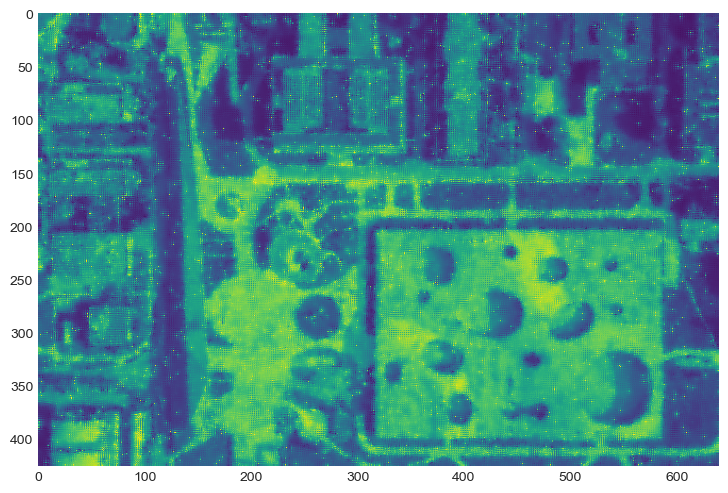

In [215]:
from pycsou.linop import Gradient
from pycsou.opt import APGD
from pycsou.func import SquaredL2Loss, SquaredL2Norm, Segment

D = Gradient(shape=input_image.shape)  # Regularisation operator
# Compute approximate Lipschitz constant for auto-tuning of step size
D.compute_lipschitz_cst(tol=1e-3)

mu = 0.1 * (Gop.lipschitz_cst ** 2 / D.lipschitz_cst ** 2)  # Penalty strength

F = ((1/2) * SquaredL2Loss(dim=y.size, data=y) * Gop) + ((mu/2) * SquaredL2Norm(dim=D.shape[0]) * D)
G = Segment(dim=input_image.size, a=0, b=1)
apgd = APGD(dim=input_image.size, F=F, G=G, verbose=None)  # Initialise APGD
out, _, _ = apgd.iterate() # Run APGD
tikhonov_estimate = out['iterand'].reshape(input_image.shape)

plt.figure()
plt.imshow(tikhonov_estimate)

With Pycsou setting upt and running APGD on this inpainting problem requires **5 lines** only!

```python
F = ((1/2) * SquaredL2Loss(dim=y.size, data=y) * Gop) 
    + ((mu/2) * SquaredL2Norm(dim=D.shape[0]) * D)
G = Segment(dim=input_image.size, a=0, b=1)
apgd = APGD(dim=input_image.size, F=F, G=G, verbose=None)  
out, _, _ = apgd.iterate() # Run APGD
tikhonov_estimate = out['iterand'].reshape(input_image.shape)
```

Without Pycsou things are **much more verbose** ! (plus you need to be an expert in proximal algorithms...)

In [ ]:
from scipy.sparse.linalg import svds

G_norm=svds(Gop.tosciop(), k=1, return_singular_vectors=False)
D_norm=svds(D.tosciop(), k=1, return_singular_vectors=False)
tau = 1 / (G_norm ** 2 + mu * D_norm ** 2)
tol = 1e-3; max_it= 500
x = x_old = z_old = 0 * input_image.flatten()
for n in range(max_it):
    z = np.clip(
        x - tau * (Gop.adjoint(Gop(x) - y) + mu * D.adjoint(D(x))),
        a_min=0,
        a_max=1,
    )
    x = z + (n / (n + 75)) * (z - z_old)
    z_old = z
    if np.linalg.norm(x - x_old) <= tol * np.linalg.norm(x_old):
        print(f"APGD converged in {n} iterations.")
        break
    x_old = x

## TV-regularised Least-Squares

$$\min_{\mathbf{x}\in\mathbb{R}^N} \underbrace{\frac{1}{2}\left\| \mathbf{y}-\mathbf{G}\mathbf{x}\right\|_2^2}_{\mathcal{F}(\mathbf{x})}\quad+\quad\underbrace{\mu\|\mathbf{D}\mathbf{x}\|_1}_{\mathcal{H}(\mathbf{K}\mathbf{x})} \quad +\quad \underbrace{\iota_{[0,1]}(\mathbf{x})}_{\mathcal{G}(\mathbf{x})}.$$

This time we have:
* $\mathcal{F}(\mathbf{x})= \frac{1}{2}\left\| \mathbf{y}-\mathbf{G}\mathbf{x}\right\|_2^2$, $\nabla\mathcal{F}(\mathbf{x})=\mathbf{G}^T(\mathbf{G}\mathbf{x}-\mathbf{y})$, $\beta=\|\mathbf{G}\|_2^2$, 
* $\mathcal{G}(\mathbf{x})=\iota_{[0,1]}(\mathbf{x})$, 
* $\mathcal{H}(\mathbf{z})=\mu\|\mathbf{z}\|_1$, $\mathbf{K}=\mathbf{D}$.

The proximal operator of $\mathbf{G}$ was already provided and the one of $\mathbf{H}$ is known: it is the *soft-thresholding operator*. 

/Users/mmjasime/Documents/Github/pycsou/pycsou/opt/proxalgs.py:374: RuntimeWarning: divide by zero encountered in double_scalars
  self.old_iterand['primal_variable'])
/Users/mmjasime/Documents/Github/pycsou/pycsou/opt/proxalgs.py:377: RuntimeWarning: divide by zero encountered in double_scalars
  self.old_iterand['dual_variable'])


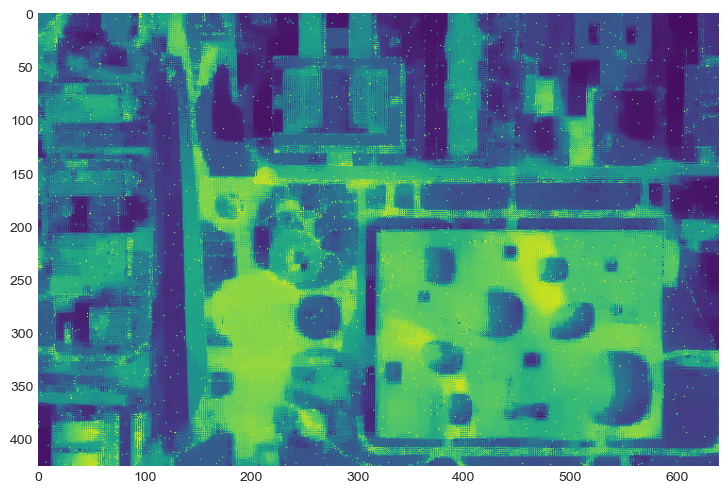

In [216]:
from pycsou.opt import PDS
from pycsou.func import L1Norm

mu = 0.035 * np.max(D(Gop.adjoint(y))) # Penalty strength

F = ((1/2) * SquaredL2Loss(dim=y.size, data=y) * Gop)
G = Segment(dim=input_image.size, a=0, b=1)
H = mu * L1Norm(dim=D.shape[0])
pds = PDS(dim=input_image.size, F=F, G=G, H=H, K=D, verbose=None)  # Initialise PDS
out, _, _ = pds.iterate() # Run PDS
tv_estimate = out['primal_variable'].reshape(input_image.shape)

plt.figure()
plt.imshow(tv_estimate)

In [ ]:
beta = G_norm ** 2
rho = 0.9
tau = sigma = (1 / D_norm ** 2) * (
    -(beta / 4) + np.sqrt((beta ** 2 / 16) + D_norm ** 2)
)
soft = lambda w, t: np.clip(np.abs(w) - mu * t, a_min=0, a_max=None) * np.sign(w)
prox_conj = lambda w, t: w - t * soft(w / t, 1 / t)
tol = 1e-3
x = x_old = 0 * input_image.flatten()
z = np.zeros(shape=(D.shape[0],))
for n in range(500):
    x_tilde = np.clip(
        x - tau * Gop.adjoint(Gop(x) - y) - tau * D.adjoint(z), a_min=0, a_max=1
    )
    z_tilde = prox_conj(z + sigma * D(2 * x_tilde - x), sigma)
    x, z = rho * x_tilde + (1 - rho) * x, rho * z_tilde + (1 - rho) * z
    if np.linalg.norm(x - x_old) <= tol * np.linalg.norm(x_old):
        print(f"PDS converged in {n} iterations.")
        break
    x_old = x

### TV-regularised Least Absolute Deviations

$$\min_{\mathbf{x}\in\mathbb{R}^N} \underbrace{\left\| \mathbf{y}-\mathbf{G}\mathbf{x}\right\|_1\quad+\quad\mu\|\mathbf{D}\mathbf{x}\|_1}_{\mathcal{H}(\mathbf{K}\mathbf{x})} \quad +\quad \underbrace{\iota_{[0,1]}(\mathbf{x})}_{\mathcal{G}(\mathbf{x})}.$$

No differentiable term anymore, but **two** composite proximable terms: we need to put more things in the $\mathcal{H}$ term... We define:
* $\mathbf{K}:\mathbb{R}^{N}\to \mathbb{R}^{L}\times \mathbb{R}^{2N}$ a linear operator given by the block matrix: 
$$\mathbf{K}=\left[\begin{array}{c}\mathbf{G}\\ \mathbf{D}\end{array}\right]\in\mathbb{R}^{(L+2N)\times N}.$$
We have $\|\mathbf{K}\|_2=\sqrt{\|\mathbf{K}^T\mathbf{K}\|_2}=\sqrt{\|\mathbf{G}^T\mathbf{G}+\mathbf{D}^T\mathbf{D}\|_2}\leq\sqrt{\|\mathbf{G}\|_2^2+\|\mathbf{D}\|_2^2} $.
* $\mathcal{H}:\mathbb{R}^{L}\times \mathbb{R}^{2N}\to \mathbb{R}\cup\{+\infty\}$ a separable function acting on block vectors $(\mathbf{w},\mathbf{v})\in\mathbb{R}^{L}\times \mathbb{R}^{2N}\cong \mathbb{R}^{L+2N}$ as: 
$$\mathcal{H}((\mathbf{v},\mathbf{w}))=\mathcal{H}_1(\mathbf{v})+\mathcal{H}_2(\mathbf{w})=\|\mathbf{y}-\mathbf{v}\|_1+\mu\|\mathbf{w}\|_1.$$
* $\mathcal{G}(\mathbf{x}):=\iota{[0,1]}(\mathbf{x})$ a *proximable* functional. 

/Users/mmjasime/Documents/Github/pycsou/pycsou/opt/proxalgs.py:374: RuntimeWarning: invalid value encountered in double_scalars
  self.old_iterand['primal_variable'])


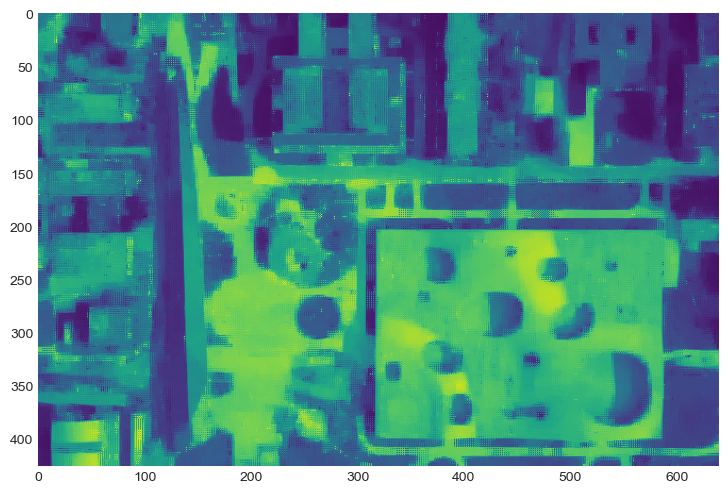

In [217]:
from pycsou.linop import LinOpVStack
from pycsou.func import L1Loss, ProxFuncHStack
from pycsou.opt import CPS

mu = 0.6
H = ProxFuncHStack(L1Loss(dim=y.size, data=y), mu * L1Norm(dim=D.shape[0]))
K = LinOpVStack(Gop, D)
G = Segment(dim=input_image.size, a=0, b=1)
cps=CPS(dim=input_image.size, G=G, H=H, K=K, verbose=None)
out,_ ,_=cps.iterate()
tv_lad_estimate = out['primal_variable'].reshape(input_image.shape)

plt.figure()
plt.imshow(tv_lad_estimate)

In [ ]:
rho = 0.9
tau = sigma = 1 / np.sqrt(D_norm ** 2 + G_norm ** 2)
soft = lambda w, t: np.clip(np.abs(w) - mu * t, a_min=0, a_max=None) * np.sign(w)
prox_conj_l1 = lambda w, t: w - t * soft(w / t, 1 / t)
soft_cost = (
    lambda w, t: np.clip(np.abs(w - y) - t, a_min=0, a_max=None) * np.sign(w - y) + y
)
prox_conj_l1df = lambda w, t: w - t * soft_cost(w / t, 1 / t)
tol = 1e-3
x = x_old = 0 * input_image.flatten()
z = np.zeros(shape=(D.shape[0],))
u = 0 * y
for n in range(500):
    x = np.clip(x - tau * Gop.adjoint(u) - tau * D.adjoint(z), a_min=0, a_max=1)
    u = prox_conj_l1df(u + sigma * Gop(2 * x - x_old), sigma)
    z = prox_conj_l1(z + sigma * D(2 * x - x_old), sigma)
    if np.linalg.norm(x - x_old) < tol * np.linalg.norm(x_old):
        print(f"PDS converged in {n} iterations.")
        break
    x_old = x
plt.imshow(x.reshape(input_image.shape))
plt.colorbar()

# Roadmap

- Implement *proximal MCMC methods* (P-MULA, Px-MALA) for uncertainty quantification
- Implement *stochastic versions* of the proximal algorithms (batch-processing)
- Implement additional common functionals (TV, GlobalBioIm functionals...)
- Implement additional common linear operators (Kronecker product/sum, DCT, FFT, FFS, Radon, wavelets...)
- Add interface/support for `CuPy` arrays allowing for GPU computations (make code agnostic with  `cupy.get_array_module`)
- Add interface/support for `PyTorch` tensors for deep learning applications 
- Add examples/tutorials to the documentation
- Make Pycsou available on Anaconda
- ...
